# QC filtering

This notebook is about filtering scATAC seq data within an adata object to archive a good quality peak matrix.
For this task various QC filters are implemented. The latter includes filters related to:

- doublet score
- number of features per barcode
- mean insert size
- promotor enrichment


## Settings

In [1]:
#Path related settings (these should be the same as for the previous notebook)
output_dir = '/home/rstudio/processed_data'
test = 'cropped_146'

## QC Settings

In [2]:
filter_xy = True  # True or False; filtering out chrX and chrY
binarize_mtx = True  # True or False; convert matrix to binary
select_hvf = False  # True or False; select only highly variable features

n_features_filter = True # True or False; filtering out cells with numbers of features not in the range defined below
# default values n_features 
min_features = 5
max_features = 10000

mean_insertsize_filter = True # True or False; filtering out cells with mean insertsize not in the range defined below
# default mean_insertsize
upper_threshold_mfl=160 
lower_threshold_mfl=80

filter_pct_fp=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
# default mean_insertsize
upper_threshold_pct_fp=0.4
lower_threshold_pct_fp=0.1

filter_n_fragments=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
# default number of fragments
upper_thr_fragments=1000000
lower_thr_fragments=2

filter_chrM_fragments=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
# default number of fragments in chrM
upper_thr_chrM_fragments=10000
lower_thr_chrM_fragments=0

filter_uniquely_mapped_fragments=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
# default number of uniquely mapped fragments
upper_thr_um=1000000
lower_thr_um=0

# plotting columns
plot_all = True # True or False; plot all columns from the infoprocess table [if False define what to plot below]
# define which columns should be plotted [if plot_all == True]
plot_cols = ["mean_fragment_length", "pct_fragments_in_promoters", "n_fragments_in_promoters", "n_total_fragments"]

## Loading packages and setup

In [4]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
from sctoolbox.qc_filter import *
from sctoolbox.plotting import *
from sctoolbox.plotting_atac import *
from sctoolbox.atac_filter import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
import numpy as np

## Setup path handling object 

In [5]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [13]:
# probably updated in future
assembling_output = tree.assembled_anndata
adata = epi.read_h5ad(assembling_output)
adata

AnnData object with n_obs × n_vars = 373 × 3830
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters'
    var: 'name'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution'

In [15]:
adata.uns['insertsize_distribution'] = adata.uns['insertsize_distribution'].swapaxes('index', 'columns')

In [16]:
adata.uns['insertsize_distribution']

,0,1,2,3,4,5,6,7,8,9,...,867,868,869,870,871,872,873,874,875,876
AAACTACCAGAAACCCGAGATA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACTACCAGAAACCTAAGTGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACTACCAGAAACGGATCAGT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACTACCAGAAACGTCCCGTT,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACTACCAGAAACTAGCCCTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AAACTACCAGCTTGGCAACAGC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACTACCAGCTTTAACTGCGC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACTACCAGCTTTAGCCCTAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACTACCAGCTTTAGCTGACT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: xlabel='Insertsize (bp)', ylabel='Count'>

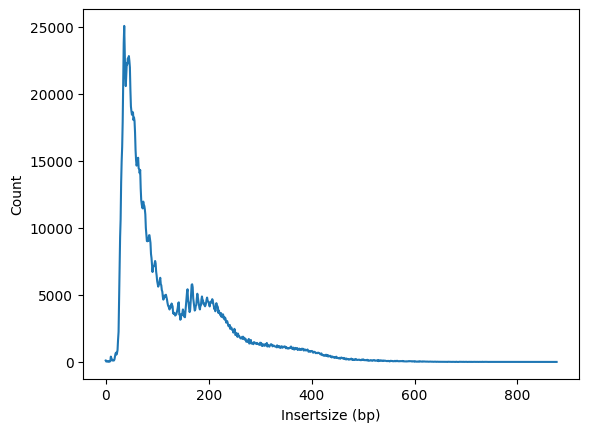

In [17]:
atac.plot_insertsize(adata)

# QC

## 1. filtering out chrX, chrY and chrM

In [10]:
non_m = [name for name in adata.var_names if not name.startswith('chrM')]  # remove chrM
adata = adata[:, non_m]

In [11]:
if filter_xy:
    non_xy = [name for name in adata.var_names if not name.startswith('chrY') | name.startswith('chrX')]
    adata = adata[:, non_xy]

In [12]:
display(adata)

View of AnnData object with n_obs × n_vars = 373 × 3830
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'mean_fragment_length', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters'
    var: 'name'
    uns: 'color_set', 'infoprocess'

## 2. removing empty cells and features

In [13]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 322 × 3746
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'mean_fragment_length', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'name', 'n_cells'
    uns: 'color_set', 'infoprocess'

## 3. binarize

In [14]:
adata.raw = adata
if binarize_mtx:
    epi.pp.binarize(adata)
    adata.layers['binary'] = adata.X.copy()

## 4. select highly variable genes

In [15]:
if select_hvf:
    select_var_feature(adata, min_score=0.5, nb_features=None, show=False, copy=False)

## 5. visualize adata

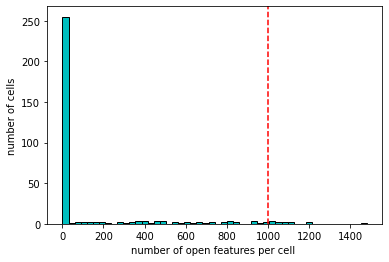

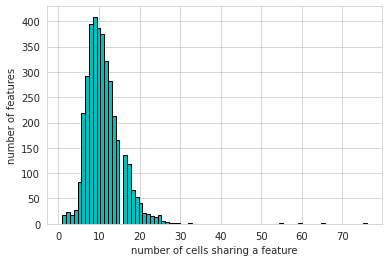

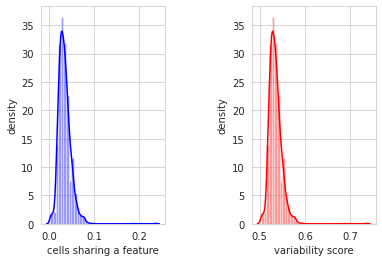

In [16]:
plot_ov_hist(adata, threshold_features=1000)

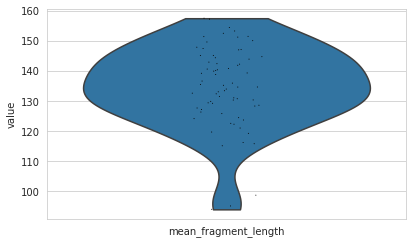

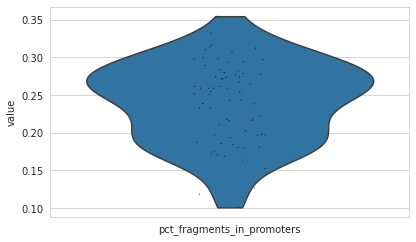

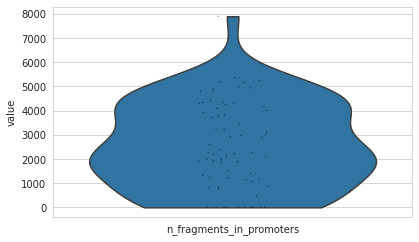

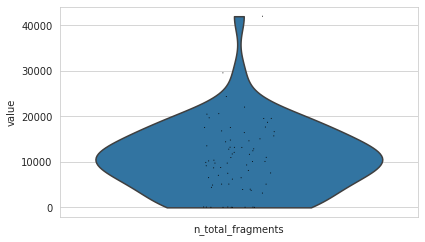

In [26]:
plot_obs_violin(adata, plot_cols)

## 6. filter cells

In [20]:
if doublet_score_filter:
    adata = estimate_doublets(adata)
    adata.obs
    
    # insert filter here

In [21]:
if n_features_filter:
    epi.pp.filter_cells(adata, min_features=min_features)
    epi.pp.filter_cells(adata, max_features=max_features)
    display(adata)

AnnData object with n_obs × n_vars = 79 × 3746
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'mean_fragment_length', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'name', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'color_set', 'infoprocess'
    layers: 'binary'

In [25]:
if mean_fl_filter:
    adata = filter_mfl(adata, upper_threshold=upper_threshold_mfl, lower_threshold=lower_threshold_mfl)
    display(adata)

View of AnnData object with n_obs × n_vars = 70 × 3746
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'mean_fragment_length', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'name', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'color_set', 'infoprocess'
    layers: 'binary'

In [23]:
if filter_pct_fp:
    adata = filter_pct_fragments_in_promoters(adata, upper_threshold=upper_threshold_pct_fp, lower_threshold=lower_threshold_pct_fp)
    display(adata)

View of AnnData object with n_obs × n_vars = 70 × 3746
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'mean_fragment_length', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'name', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'color_set', 'infoprocess'
    layers: 'binary'

## 7. save plots

In [ ]:
# implement save plots //plot functions have to be modified 

## 8. save adata

In [ ]:
# implement save adata //path has to be added to atac_tree.py